# Single time step prediction
## — with single input 

In [51]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from darts.datasets import EnergyDataset
from darts.dataprocessing.transformers import MissingValuesFiller
import numpy as np

from ontime.module import preprocessing

In [52]:
input_length = 10
target_length = 3
nb_neurons_hidden_layer = 8
shift_between_batches = 3
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
## Load data

In [53]:
energy_ts = EnergyDataset().load()
energy_ts = energy_ts.astype(np.float32)
single_ts = energy_ts.univariate_component(0)

---
## Preprocessing

In [54]:
# Fill missing values
transformer = MissingValuesFiller()
single_ts = transformer.transform(single_ts)

# Normalize
single_ts = preprocessing.common.normalize(single_ts)

# Train test split
train, test = preprocessing.common.train_test_split(single_ts, train_split=0.8)

# Split in vectors of length n
train_list = preprocessing.common.split_by_length(train, length=input_length + target_length, shift=shift_between_batches)
test_list = preprocessing.common.split_by_length(test, length=input_length + target_length, shift=shift_between_batches)

# Split each vector in input and target
X_train, y_train = preprocessing.common.split_inputs_from_targets(train_list, input_length=input_length,
                                                                  target_length=target_length)
X_test, y_test = preprocessing.common.split_inputs_from_targets(test_list, input_length=input_length,
                                                                target_length=target_length)

# Convert to Numpy
X_train = preprocessing.common.timeseries_list_to_numpy(X_train)
y_train = preprocessing.common.timeseries_list_to_numpy(y_train)
X_test = preprocessing.common.timeseries_list_to_numpy(X_test)
y_test = preprocessing.common.timeseries_list_to_numpy(y_test)

In [55]:
X_train = np.squeeze(X_train, axis=-1)
y_train = np.squeeze(y_train, axis=-1)
X_test = np.squeeze(X_test, axis=-1)
y_test = np.squeeze(y_test, axis=-1)

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9346, 10)
(9346, 3)
(2334, 10)
(2334, 3)


---
## Modelling

In [57]:
# Convert X_train and y_train to PyTorch tensors if not already
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).float().to(device)

class ModelDataset(Dataset): 
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = ModelDataset(X_train_tensor, y_train_tensor)
data_loader = DataLoader(ds, batch_size=input_length, shuffle=True)

In [58]:
item = iter(data_loader)
next(item)

[tensor([[0.6132, 0.6098, 0.6047, 0.6115, 0.5997, 0.6267, 0.6284, 0.6267, 0.6267,
          0.6233],
         [0.5676, 0.5709, 0.5811, 0.5811, 0.5743, 0.5659, 0.5693, 0.5625, 0.5726,
          0.5693],
         [0.7584, 0.7517, 0.7432, 0.7601, 0.7652, 0.7821, 0.7889, 0.7872, 0.7939,
          0.7838],
         [0.6436, 0.6436, 0.6436, 0.6419, 0.6419, 0.6470, 0.6368, 0.6301, 0.6301,
          0.6166],
         [0.7247, 0.7280, 0.7264, 0.7230, 0.7230, 0.7145, 0.7179, 0.7213, 0.7247,
          0.7111],
         [0.6132, 0.6149, 0.6166, 0.6182, 0.6199, 0.6199, 0.6132, 0.6267, 0.6402,
          0.6436],
         [0.5557, 0.5591, 0.5693, 0.5659, 0.5676, 0.6318, 0.6486, 0.6419, 0.6436,
          0.6402],
         [0.9493, 0.9561, 0.9561, 0.9696, 0.9679, 0.9578, 0.9578, 0.9578, 0.9476,
          0.9392],
         [0.6199, 0.6182, 0.6216, 0.6216, 0.6216, 0.6182, 0.6199, 0.6233, 0.6284,
          0.6334],
         [0.6486, 0.6419, 0.6588, 0.6672, 0.6655, 0.6706, 0.6453, 0.6402, 0.6402,
         

In [59]:
model = nn.Sequential(
    nn.Linear(input_length, nb_neurons_hidden_layer),
    nn.ReLU(),
    nn.Linear(nb_neurons_hidden_layer, target_length),
).to(device)

# Define the loss function and optimizer
loss = nn.MSELoss()

from torch.optim import SGD
import time

optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

losses = []
start = time.time()
for epoch in range(num_epochs):
    for X, y in data_loader:
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(X)
        # Compute Loss
        l = loss(y_pred, y)
        # Backward pass
        l.backward()
        # Update weights
        optimizer.step()
        # Reset the gradients
        optimizer.zero_grad()
        losses.append(l.item())
    print(f'Epoch {epoch}/{num_epochs} - Loss: {l.item():.4f}')
end = time.time()
print(f'Training time: {end - start}s')

Epoch 0/5 - Loss: 0.0006
Epoch 1/5 - Loss: 0.0002
Epoch 2/5 - Loss: 0.0018
Epoch 3/5 - Loss: 0.0001
Epoch 4/5 - Loss: 0.0004
Training time: 2.344731330871582s


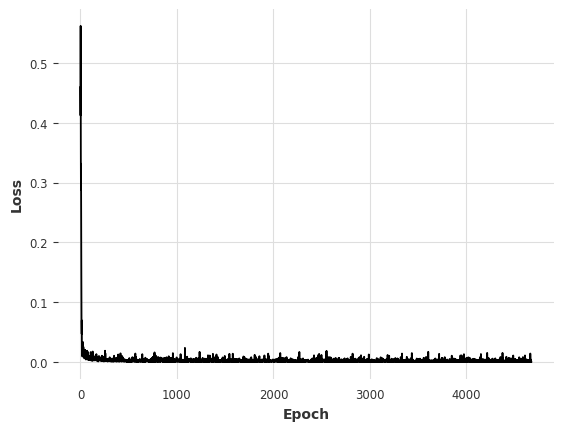

In [60]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Evaluate 

In [61]:
# Convert X_val and y_val to PyTorch tensors if not already
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Set the model to evaluation mode
model.eval()
criterion = nn.MSELoss()
# Forward pass on the validation set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

print(f'Validation Loss: {test_loss.item():.4f}')


Validation Loss: 0.0013


---
## Predict

In [62]:
print(f'Number of prediction samples: {target_length}')
prediction = model(X_test_tensor)
print(f'Actual prediction length {len(prediction[0])}')

if target_length != len(prediction[0]):
    raise ValueError('Prediction length is not equal to target length')

Number of prediction samples: 3
Actual prediction length 3


In [63]:
# Forward pass on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)

# Convert the tensor results back to a NumPy array
predicted_values = test_outputs.numpy()

In [64]:
print(f'Predicted values shape: {predicted_values.shape}')
print(f'Actual values shape: {y_test.shape}')
print(f'Single_ts shape: {len(single_ts)}')

Predicted values shape: (2334, 3)
Actual values shape: (2334, 3)
Single_ts shape: 35064


---
## Plot results

Plot results for each possible target. We are predicting that why we have multiple graphs.

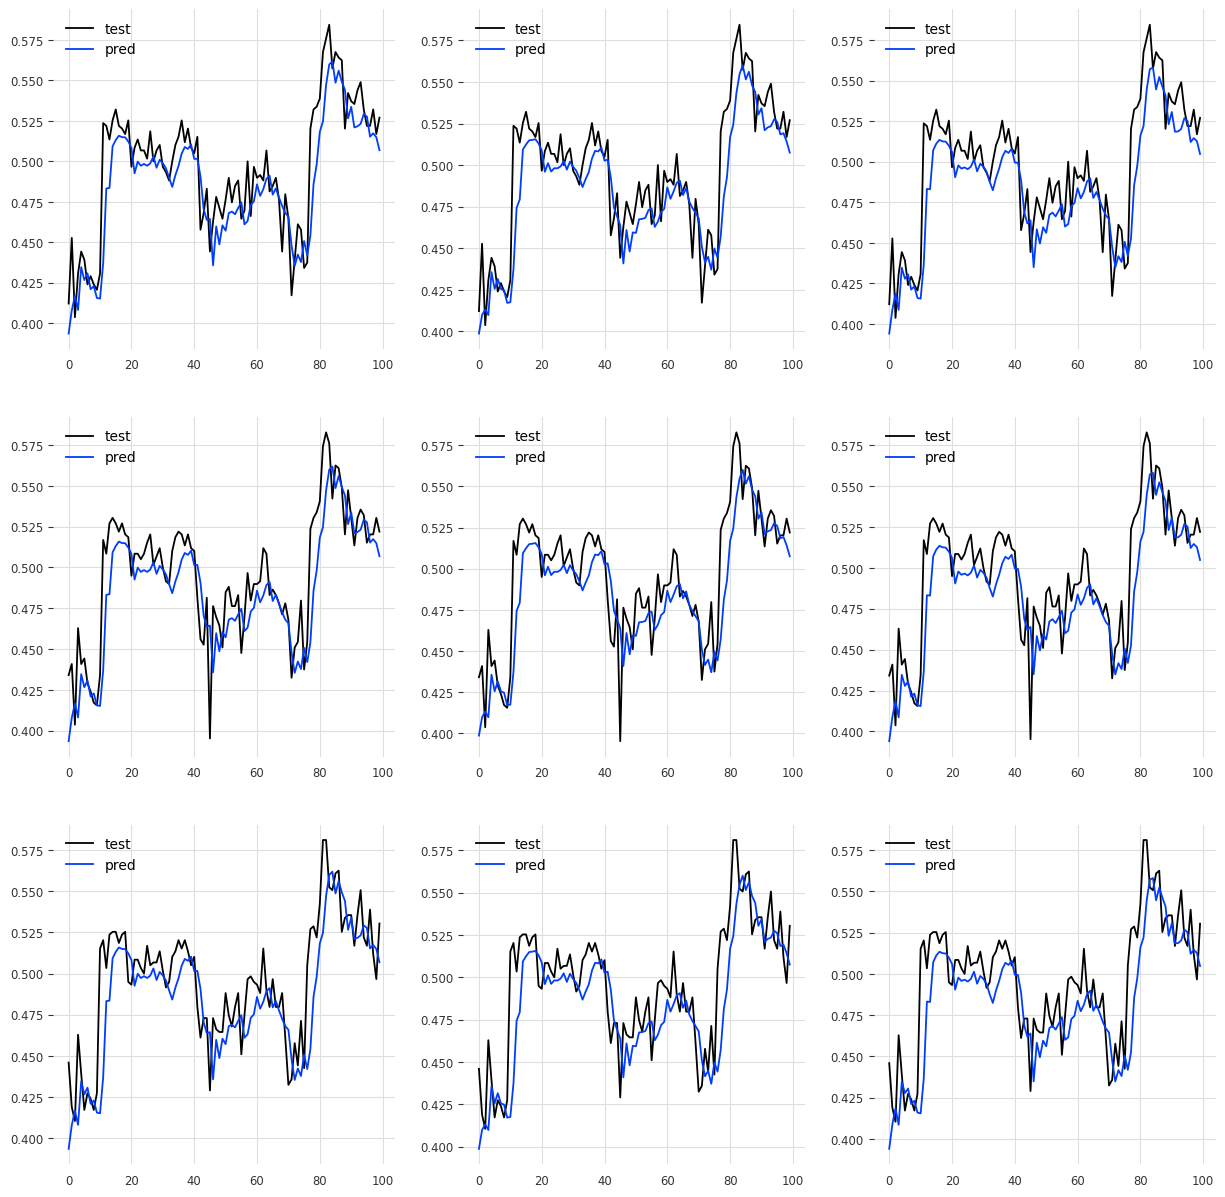

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

start = 0
width = 100

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Loop through the subplots and plot the data
for i in range(3):
    for j in range(3):
        ax = axs[i, j]
        pd.DataFrame(y_test[:, i].squeeze()[start:start + width]).plot(ax=ax)
        pd.DataFrame(predicted_values[:, j].squeeze()[start:start + width]).plot(ax=ax)
        ax.legend(['test', 'pred'])